<a href="https://colab.research.google.com/github/zine1919/Projets/blob/main/Analyse_des_sentiments_pour_le_dialecte_marocain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import re

def lowercase(text): #Convertir en minuscules
    return text.lower()

def remove_digits(text): #Supprimer les chiffres
    return re.sub("[0-9]", "", text)

def remove_extra_spaces(text): #Remplacer les espaces multiples par un seul espace
    text = re.sub(" +", " ", text)
    return text

def remove_links(text): #Supprimer les liens (URLs)
    text = re.sub(r"http\S+", " ", text, flags=re.MULTILINE)
    return text

def remove_tags_hash(text): #Supprimer les mentions @ et les hashtags #

    arabic_username_pattern = r"@[\u0600-\u06FF]+"
    arabic_hashtag_pattern = r"#[\u0600-\u06FF]+"

    text = re.sub(arabic_username_pattern, " ", text)
    text = re.sub(arabic_hashtag_pattern, " ", text)

    text = re.sub(r"(@[A-Za-z0-9_]+)", " ", text)
    text = re.sub(r"(#[A-Za-z0-9_]+)", " ", text)
    return text

def remove_repeated(text): #Supprimer les caractères répétés
    return re.sub(r"(.)\1+", r"\1\1", text)

def remove_empty_lines(text): #Supprimer les lignes vides
    lines = text.split("\n")
    return ("\n").join([line for line in lines if len(line) > 1])

def normalize_letter(text):
    letters = {
        "ت": list("تث"),
        "د": list("دذ"),
        "ض": list("ظض"),
        "ا": list('اأإئآؤء'),
    }
    letters_map = dict(
        {
            letter: k
            for k, letters_list in letters.items()
            for letter in letters_list
        }
    )
    normalized_text = text.translate(str.maketrans(letters_map))
    return normalized_text

def remove_chakl(text):

    if not text:
        return text
    tashkeel_regex = re.compile(r"[\u064b-\u0652]")
    return tashkeel_regex.sub("", text)

def replace_french_with_arabic(text): #Remplacer les lettres françaises par leurs équivalents arabes
    french_to_arabic = {
        'a': 'ا', 'b': 'ب',
        'c': 'س', 'd': 'د',
        'e': u'\u064f', 'f': 'ف',
        'g': 'ج', 'h': 'ه',
        'i': u'\u0650', 'j': 'ج',
        'k': 'ك', 'l': 'ل',
        'm': 'م', 'n': 'ن',
        'o': 'و', 'p': 'ب',
        'q': 'ق', 'r': 'ر',
        's': 'س', 't': 'ت',
        'u': 'و', 'v': 'ف',
        'w': 'و', 'x': 'كس',
        'y': 'ي', 'z': 'ز',
        '3':'ع', '5':'خ',
        '9':'ق'
    }
    result = []
    for char in text:
        if char.isalpha() and char.lower() in french_to_arabic:
            replacement = french_to_arabic[char.lower()]
            result.append(replacement)
        else:
            result.append(char)
    return ''.join(result)

def custom_replace359(text):

    replacements = {
        '3': 'ع',
        '5': 'خ',
        '9': 'ق',
        '7': 'ح',
        '2':'ا'
    }

    result = []
    i = 0
    while i < len(text):
        char = text[i]
        if char.isdigit() and char in replacements:
            prev_char = text[i-1] if i-1 >= 0 else None
            next_char = text[i+1] if i+1 < len(text) else None

            if (prev_char is None or not prev_char.isdigit()) and (next_char is None or not next_char.isdigit()):
                result.append(replacements[char])
            else:
                result.append(char)
        else:
            result.append(char)

        i += 1

    return ''.join(result)

def clean_text(text): #Appliquer la séquence de fonctions précédentes
    text=remove_empty_lines(text)
    text=remove_extra_spaces(text)
    text=lowercase(text)
    text=remove_tags_hash(text)
    text=replace_french_with_arabic(text)
    text=remove_chakl(text)
    text=custom_replace359(text)
    text=normalize_letter(text)
    text=remove_repeated(text)
    text=remove_digits(text)

    return text

def load_darija_stop_words(file_path):

    with open(file_path, 'r', encoding='utf-8') as file:
        stop_words = {word.strip() for word in file}
    return stop_words

def darija_stop_words_removal(text, stop_words):

    words = text.split()
    cleaned_words = [word for word in words if word not in stop_words]
    return " ".join(cleaned_words)



import nltk
from nltk.tokenize import word_tokenize
def word_tokenize(text):
    text = re.sub(r"[^\w\s]", "", text)
    words = text.split()
    return words

def clean_all_values(df):
    df['text'] = df['text'].astype(str)
    df['text'] = df['text'].apply(clean_text)
    return df

def stopwordsdarija(df, stop_words_file):
    stop_words = load_darija_stop_words(stop_words_file)
    df['text'] = df['text'].apply(lambda text: darija_stop_words_removal(text, stop_words))
    return df



In [ ]:
# Importer les bibliothèques nécessaires
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

# Charger le fichier CSV
data = pd.read_csv("/content/all2.csv", header=0)
data.drop_duplicates(inplace=True)

#applying the cleaning
data = clean_all_values(data)
#data = stopwordsdarija(data, '/content/stop_words.txt')

# Sélectionner les colonnes
data = data[['text', 'Label']]
data = data[data['Label'] != 'Neutral']
texts = data['text']  # Extraire les textes
tags = data['Label']  # Extraire les labels

# Partition des données en ensembles d'entraînement et de test
texts_train, texts_test, tags_train, tags_test = train_test_split(texts, tags, test_size=0.2, random_state=42)

# Créer le vectoriseur avec le tokenizer personnalisé
tokenizer = CountVectorizer(tokenizer=word_tokenize)

# Extraction des caractéristiques des textes en utilisant le tokenizer personnalisé
x_train = tokenizer.fit_transform(texts_train)
x_test = tokenizer.transform(texts_test)

encoder = LabelEncoder()  # Créer un encodeur de labels
encoder.fit(tags_train)  # Entraîner l'encodeur sur les labels d'entraînement
num_classes = len(encoder.classes_)  # Nombre de classes (labels)

# Convertir les labels en valeurs numériques encodées
y_train = encoder.transform(tags_train)
y_test = encoder.transform(tags_test)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
# Créer et entraîner le modèle de réseau neuronal multicouche
model = MLPClassifier(hidden_layer_sizes=(1024, 1024), alpha=1e-5, activation='relu', solver='adam', learning_rate_init=0.01, random_state=1)
model.fit(x_train, y_train)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(1024, 1024),
              learning_rate_init=0.01, random_state=1)

In [ ]:
# Prédiction sur l'ensemble de test
y_pred_test = model.predict(x_test)
# Prédiction sur l'ensemble de training
y_pred_train = model.predict(x_train)

In [ ]:
exactitude_train = accuracy_score(y_pred_train, y_train)
exactitude_test = accuracy_score(y_pred_test, y_test)
print("Exactitude sur le Train set:", exactitude_train)
print("Exactitude sur le Test set:", exactitude_test)

Exactitude sur le Train set: 0.9973492379058979
Exactitude sur le Test set: 0.8622151563328034


In [ ]:
# Fonction de prédiction du label
def predict_label(text):
    preprocessed_text = tokenizer.transform([text])  # Convertir le texte en représentation vectorielle
    predicted_label = model.predict(preprocessed_text)  # Faire la prédiction
    predicted_label = encoder.inverse_transform(predicted_label)  # Convertir les valeurs numériques en labels
    print("Le label prédit est :", predicted_label[0])

In [ ]:
# Repeatedly ask for new text input and predict the label
while True:
    # Input a text for prediction
    text_input = input('Entrez un texte (ou tapez "q" pour quitter) : ')
    if text_input.lower() == 'q':
        break
    predict_label(text_input)

Entrez un texte (ou tapez "q" pour quitter) : ما خدمة ما والو
Le label prédit est : Positive
Entrez un texte (ou tapez "q" pour quitter) : اش هاد السيربيس عندكم كليان زايد ناقص شحال وانا منشور قدام لاجونص و فلخر فاش وصلات نوبتي ديك خليتي كاتنفخ بحالا هي اللي غتعطيني من فلوسها
Le label prédit est : Neutral
Entrez un texte (ou tapez "q" pour quitter) : صالون غزال و غايمشي بعيد، ليكيب بروفسيونيل، جربت بزاف ليساج ولكن راه ليساج بلاك دايمند. يالهم ما كينش حسن منو
Le label prédit est : Negative
Entrez un texte (ou tapez "q" pour quitter) : واحد الريزو ديال الله احسن العوان اوصافي
Le label prédit est : Negative
Entrez un texte (ou tapez "q" pour quitter) : هاااا القوالب لي مابغيناش😡
Le label prédit est : Neutral
Entrez un texte (ou tapez "q" pour quitter) : انوي مزيانا و مخيرة ف المغرب كامل
Le label prédit est : Neutral
Entrez un texte (ou tapez "q" pour quitter) : q


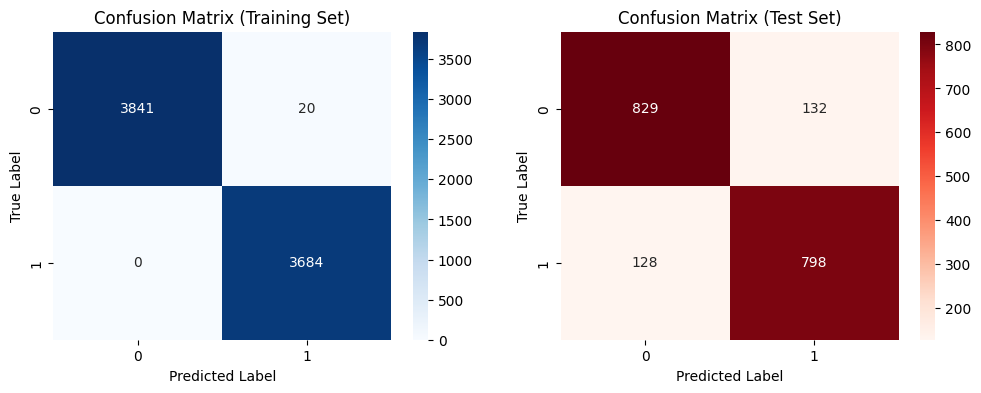

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# Training set confusion matrix
sns.heatmap(confusion_matrix(y_train, y_pred_train), annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix (Training Set)')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
# Test set confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='d', cmap='Reds', ax=axes[1])
axes[1].set_title('Confusion Matrix (Test Set)')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
plt.show()

In [ ]:
# Créer et entraîner le modèle de réseau neuronal multicouche
model1 = MLPClassifier(hidden_layer_sizes=(1024,), activation='relu', solver='adam', learning_rate_init=0.001)
model1.fit(x_train, y_train)

MLPClassifier(hidden_layer_sizes=(1024,))

In [ ]:
# Prédiction sur l'ensemble de test
y_pred_test1 = model1.predict(x_test)
# Prédiction sur l'ensemble de training
y_pred_train1 = model1.predict(x_train)

from sklearn.metrics import accuracy_score
exactitude_train1 = accuracy_score(y_pred_train1, y_train)
exactitude_test1 = accuracy_score(y_pred_test1, y_test)
print("Exactitude sur le Train set:", exactitude_train1)
print("Exactitude sur le Test set:", exactitude_test1)

Exactitude sur le Train set: 0.9973492379058979
Exactitude sur le Test set: 0.8823529411764706


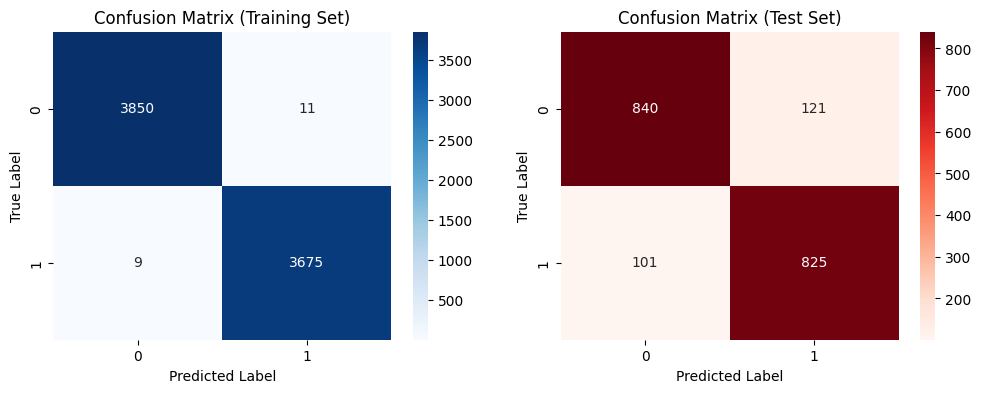

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# Training set confusion matrix
sns.heatmap(confusion_matrix(y_train, y_pred_train1), annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix (Training Set)')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
# Test set confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_test1), annot=True, fmt='d', cmap='Reds', ax=axes[1])
axes[1].set_title('Confusion Matrix (Test Set)')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
plt.show()

In [ ]:
confusion_matrix(y_test, y_pred_test1)

array([[840, 121],
       [101, 825]])

In [ ]:
# Créer et entraîner le modèle de réseau neuronal multicouche
model3 = MLPClassifier(hidden_layer_sizes=(1024, 1024), alpha=1e-5, activation='relu', solver='adam', learning_rate_init=0.001, random_state=1)
model3.fit(x_train, y_train)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(1024, 1024), random_state=1)

In [ ]:
# Prédiction sur l'ensemble de test
y_pred_test3 = model3.predict(x_test)
# Prédiction sur l'ensemble de training
y_pred_train3 = model3.predict(x_train)

In [ ]:
exactitude_train3 = accuracy_score(y_pred_train3, y_train)
exactitude_test3 = accuracy_score(y_pred_test3, y_test)
print("Exactitude sur le Train set:", exactitude_train3)
print("Exactitude sur le Test set:", exactitude_test3)

Exactitude sur le Train set: 0.9973492379058979
Exactitude sur le Test set: 0.8749337572866984


In [ ]:
# Calculer le nombre d'occurrences de chaque label
label_counts = data['Label'].value_counts()
print(label_counts)

Negative    4822
Positive    4610
Neutral      630
Name: Label, dtype: int64


In [ ]:
data = data[data['Label'] != 'Neutral']

In [ ]:
# Calculer le nombre d'occurrences de chaque label
label_counts = data['Label'].value_counts()

print(label_counts)

Negative    4822
Positive    4610
Name: Label, dtype: int64
